In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
from copy import copy
import cortex
import cortex.polyutils

import numpy as np
import pandas as pd
import pickle
import torch

from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

def read_pickle(path):
    with open(path, 'rb') as f:
        data = pickle.load(f)
    return data

In [2]:
import nibabel as nib

def extract_roi_mask(subj, roi_name):
    """
    Extracts the mask of a given ROI for a given subject.
    
    Parameters:
    -----------
    subj: int
        Subject number.
    roi: str
        ROI name.
    
    Returns:
    --------
    roi_mask: np.ndarray
        ROI mask.
    """
    nsdgeneral_mask = nib.load(f'/SSD/slava/THESIS/NSD_processed/subj0{subj}/roi/nsdgeneral.nii.gz').get_fdata()


    if 'Visual' in roi_name:
        visual_roi = nib.load(f'/SSD/slava/THESIS/NSD_processed/subj0{subj}/roi/prf-visualrois.nii.gz').get_fdata()
        
        if 'V1' in roi_name:
            roi = np.zeros_like(nsdgeneral_mask)
            roi[visual_roi==1] = 1
            roi[visual_roi==2] = 1
        elif 'V2' in roi_name:
            roi = np.zeros_like(nsdgeneral_mask)
            roi[visual_roi==3] = 1
            roi[visual_roi==4] = 1
        elif 'V3' in roi_name:
            roi = np.zeros_like(nsdgeneral_mask)
            roi[visual_roi==5] = 1
            roi[visual_roi==6] = 1
        elif 'V4' in roi_name:
            roi = np.zeros_like(nsdgeneral_mask)
            roi[visual_roi==7] = 1
        else:
            # all visual
            roi = visual_roi
    elif roi_name=='floc-words':
        roi = nib.load(f'/SSD/slava/THESIS/NSD_processed/subj0{subj}/roi/floc-words.nii.gz').get_fdata()
    elif roi_name=='floc-faces':
        roi = nib.load(f'/SSD/slava/THESIS/NSD_processed/subj0{subj}/roi/floc-faces.nii.gz').get_fdata()
    elif roi_name=='floc-places':
        roi = nib.load(f'/SSD/slava/THESIS/NSD_processed/subj0{subj}/roi/floc-places.nii.gz').get_fdata()
    elif roi_name=='floc-bodies':
        roi = nib.load(f'/SSD/slava/THESIS/NSD_processed/subj0{subj}/roi/floc-bodies.nii.gz').get_fdata()
    elif roi_name=='Higher Areas':
#         visual_roi = nib.load(f'/SSD/slava/THESIS/NSD_processed/subj0{subj}/roi/prf-visualrois.nii.gz').get_fdata()
#         roi = np.zeros_like(nsdgeneral_mask)
#         roi[visual_roi==7] = 1
        flocs = np.array([
            nib.load(f'/SSD/slava/THESIS/NSD_processed/subj0{subj}/roi/floc-words.nii.gz').get_fdata(),
            nib.load(f'/SSD/slava/THESIS/NSD_processed/subj0{subj}/roi/floc-faces.nii.gz').get_fdata(),
            nib.load(f'/SSD/slava/THESIS/NSD_processed/subj0{subj}/roi/floc-places.nii.gz').get_fdata(),
            nib.load(f'/SSD/slava/THESIS/NSD_processed/subj0{subj}/roi/floc-bodies.nii.gz').get_fdata()
                ])
        
        roi = flocs.sum(axis=0)
        
    elif roi_name=='Overall':
        roi = nsdgeneral_mask
    else:
        raise ValueError('Unknown roi_name')

    roi = roi[nsdgeneral_mask>0]
    roi[roi<0] = 0
    roi[roi>0] = 1
    
    return roi

In [26]:
! ls alignment_scores/subj01/general/vision/*neural_predictivity*

alignment_scores/subj01/general/vision/convnext_neural_predictivity.pkl
alignment_scores/subj01/general/vision/efficientnet_neural_predictivity_top10.pkl
alignment_scores/subj01/general/vision/resnet_neural_predictivity_top10.pkl
alignment_scores/subj01/general/vision/vit_clip_neural_predictivity_top10.pkl
alignment_scores/subj01/general/vision/vit_dinov2_neural_predictivity_top10.pkl
alignment_scores/subj01/general/vision/vit_mae_neural_predictivity_top10.pkl
alignment_scores/subj01/general/vision/vit_neural_predictivity_top10.pkl


In [4]:
results_db = []
subj = 1
mask_names = ['Higher Areas', 'Visual-V1', 'Visual-V2', 'Visual-V3', 'Visual-V4', 'Visual',
                'floc-faces', 'floc-places', 'floc-bodies', 'floc-words', 'Overall']
            

all_model_names = []
    
for pkl_file in glob('alignment_scores/subj01/general/vision/*neural_predictivity*'):
    data = read_pickle(pkl_file)
    for k, v in data.items():
        
        key_parts = k.split('_')
        pooling = key_parts[-1]
        layer = key_parts[-2]
        model_name = ''.join(key_parts[:-2])
        all_model_names.append(model_name)
        assert len(v['score'])==1
        num_params = v['num_params']
        
        if 'dinov2' in model_name:
            family = 'ViT DINOv2'
        elif '.mae' in model_name:
            family = 'ViT MAE'
        elif 'resnet' in model_name:
            family = 'ResNet'
        elif 'laion2bftin12k' in model_name:
            family = 'Finetuned ViT CLIP'
        elif 'clip' in model_name:
            family = 'ViT CLIP'
        elif 'efficient' in model_name:
            family = 'Efficient Net'
        elif '.augregin21k' in model_name:
            family = 'ViT'
        elif '.fcmaeftin22kin1k384' in model_name:
            family = 'ConvNeXt V2'
        
        res = {
            'model': model_name,
            'layer': layer,
            'pooling': pooling,
            'family': family,
            'num_params': num_params,
        }
        
        for mask_name in mask_names:
            roi_mask = extract_roi_mask(subj, mask_name)
            res[mask_name] = v['score'][(0, 0)][roi_mask>0].mean()
            
        results_db.append(res)
        

for pkl_file in glob('alignment_scores/subj01/general/language/*neural_predictivity*'):
    data = read_pickle(pkl_file)
    for k, v in data.items():
        key_parts = k.split('_')
        pooling = key_parts[-1]
        num_params = v['num_params']
        model_name = ''.join(key_parts[:-2])
        
        if 'bigscience' in model_name:
            family = 'Bloomz'
        elif 'openlm' in model_name:
            family = 'OpenLLaMA'
        elif 'huggyllama' in model_name:
            family = 'LLaMA'
        
        for key, score in v['score'].items():
            layer = f'layer_{key[1]}'
            
            res = {
                'model': model_name,
                'layer': layer,
                'pooling': pooling,
                'family': family,
                'num_params': num_params,
                }
            
            for mask_name in mask_names:
                roi_mask = extract_roi_mask(subj, mask_name)
                res[mask_name] = score[roi_mask>0].mean()

            results_db.append(res)
        
        
        

In [5]:
results_db = pd.DataFrame(results_db)

In [6]:
results_db.head()

,model,layer,pooling,family,num_params,Higher Areas,Visual-V1,Visual-V2,Visual-V3,Visual-V4,Visual,floc-faces,floc-places,floc-bodies,floc-words,Overall
0,vitsmallpatch14reg4dinov2.lvd142m,blocks.0,mean,ViT DINOv2,22057344,0.113794,0.199429,0.137112,0.128946,0.132065,0.152351,0.099494,0.122008,0.118009,0.094232,0.120525
1,vitsmallpatch14reg4dinov2.lvd142m,blocks.1,mean,ViT DINOv2,22057344,0.142586,0.221468,0.160578,0.151514,0.149935,0.174349,0.124571,0.163919,0.145762,0.107443,0.144567
2,vitsmallpatch14reg4dinov2.lvd142m,blocks.2,mean,ViT DINOv2,22057344,0.159059,0.228869,0.172117,0.165048,0.161681,0.185227,0.135216,0.187435,0.160432,0.119751,0.157818
3,vitsmallpatch14reg4dinov2.lvd142m,blocks.3,mean,ViT DINOv2,22057344,0.178408,0.237677,0.187664,0.184674,0.174046,0.199391,0.151907,0.209262,0.183069,0.131125,0.173847
4,vitsmallpatch14reg4dinov2.lvd142m,blocks.4,mean,ViT DINOv2,22057344,0.205794,0.238634,0.193253,0.193400,0.179810,0.204463,0.178369,0.231558,0.221269,0.147126,0.190562


In [7]:
len(results_db['family'].unique()), results_db['family'].unique()

(11,
 array(['ViT DINOv2', 'ConvNeXt V2', 'Efficient Net', 'ViT',
        'Finetuned ViT CLIP', 'ResNet', 'ViT MAE', 'ViT CLIP', 'LLaMA',
        'OpenLLaMA', 'Bloomz'], dtype=object))

In [27]:
results_db.columns

Index(['model', 'layer', 'pooling', 'family', 'num_params', 'Higher Areas',
       'Visual-V1', 'Visual-V2', 'Visual-V3', 'Visual-V4', 'Visual',
       'floc-faces', 'floc-places', 'floc-bodies', 'floc-words', 'Overall'],
      dtype='object')

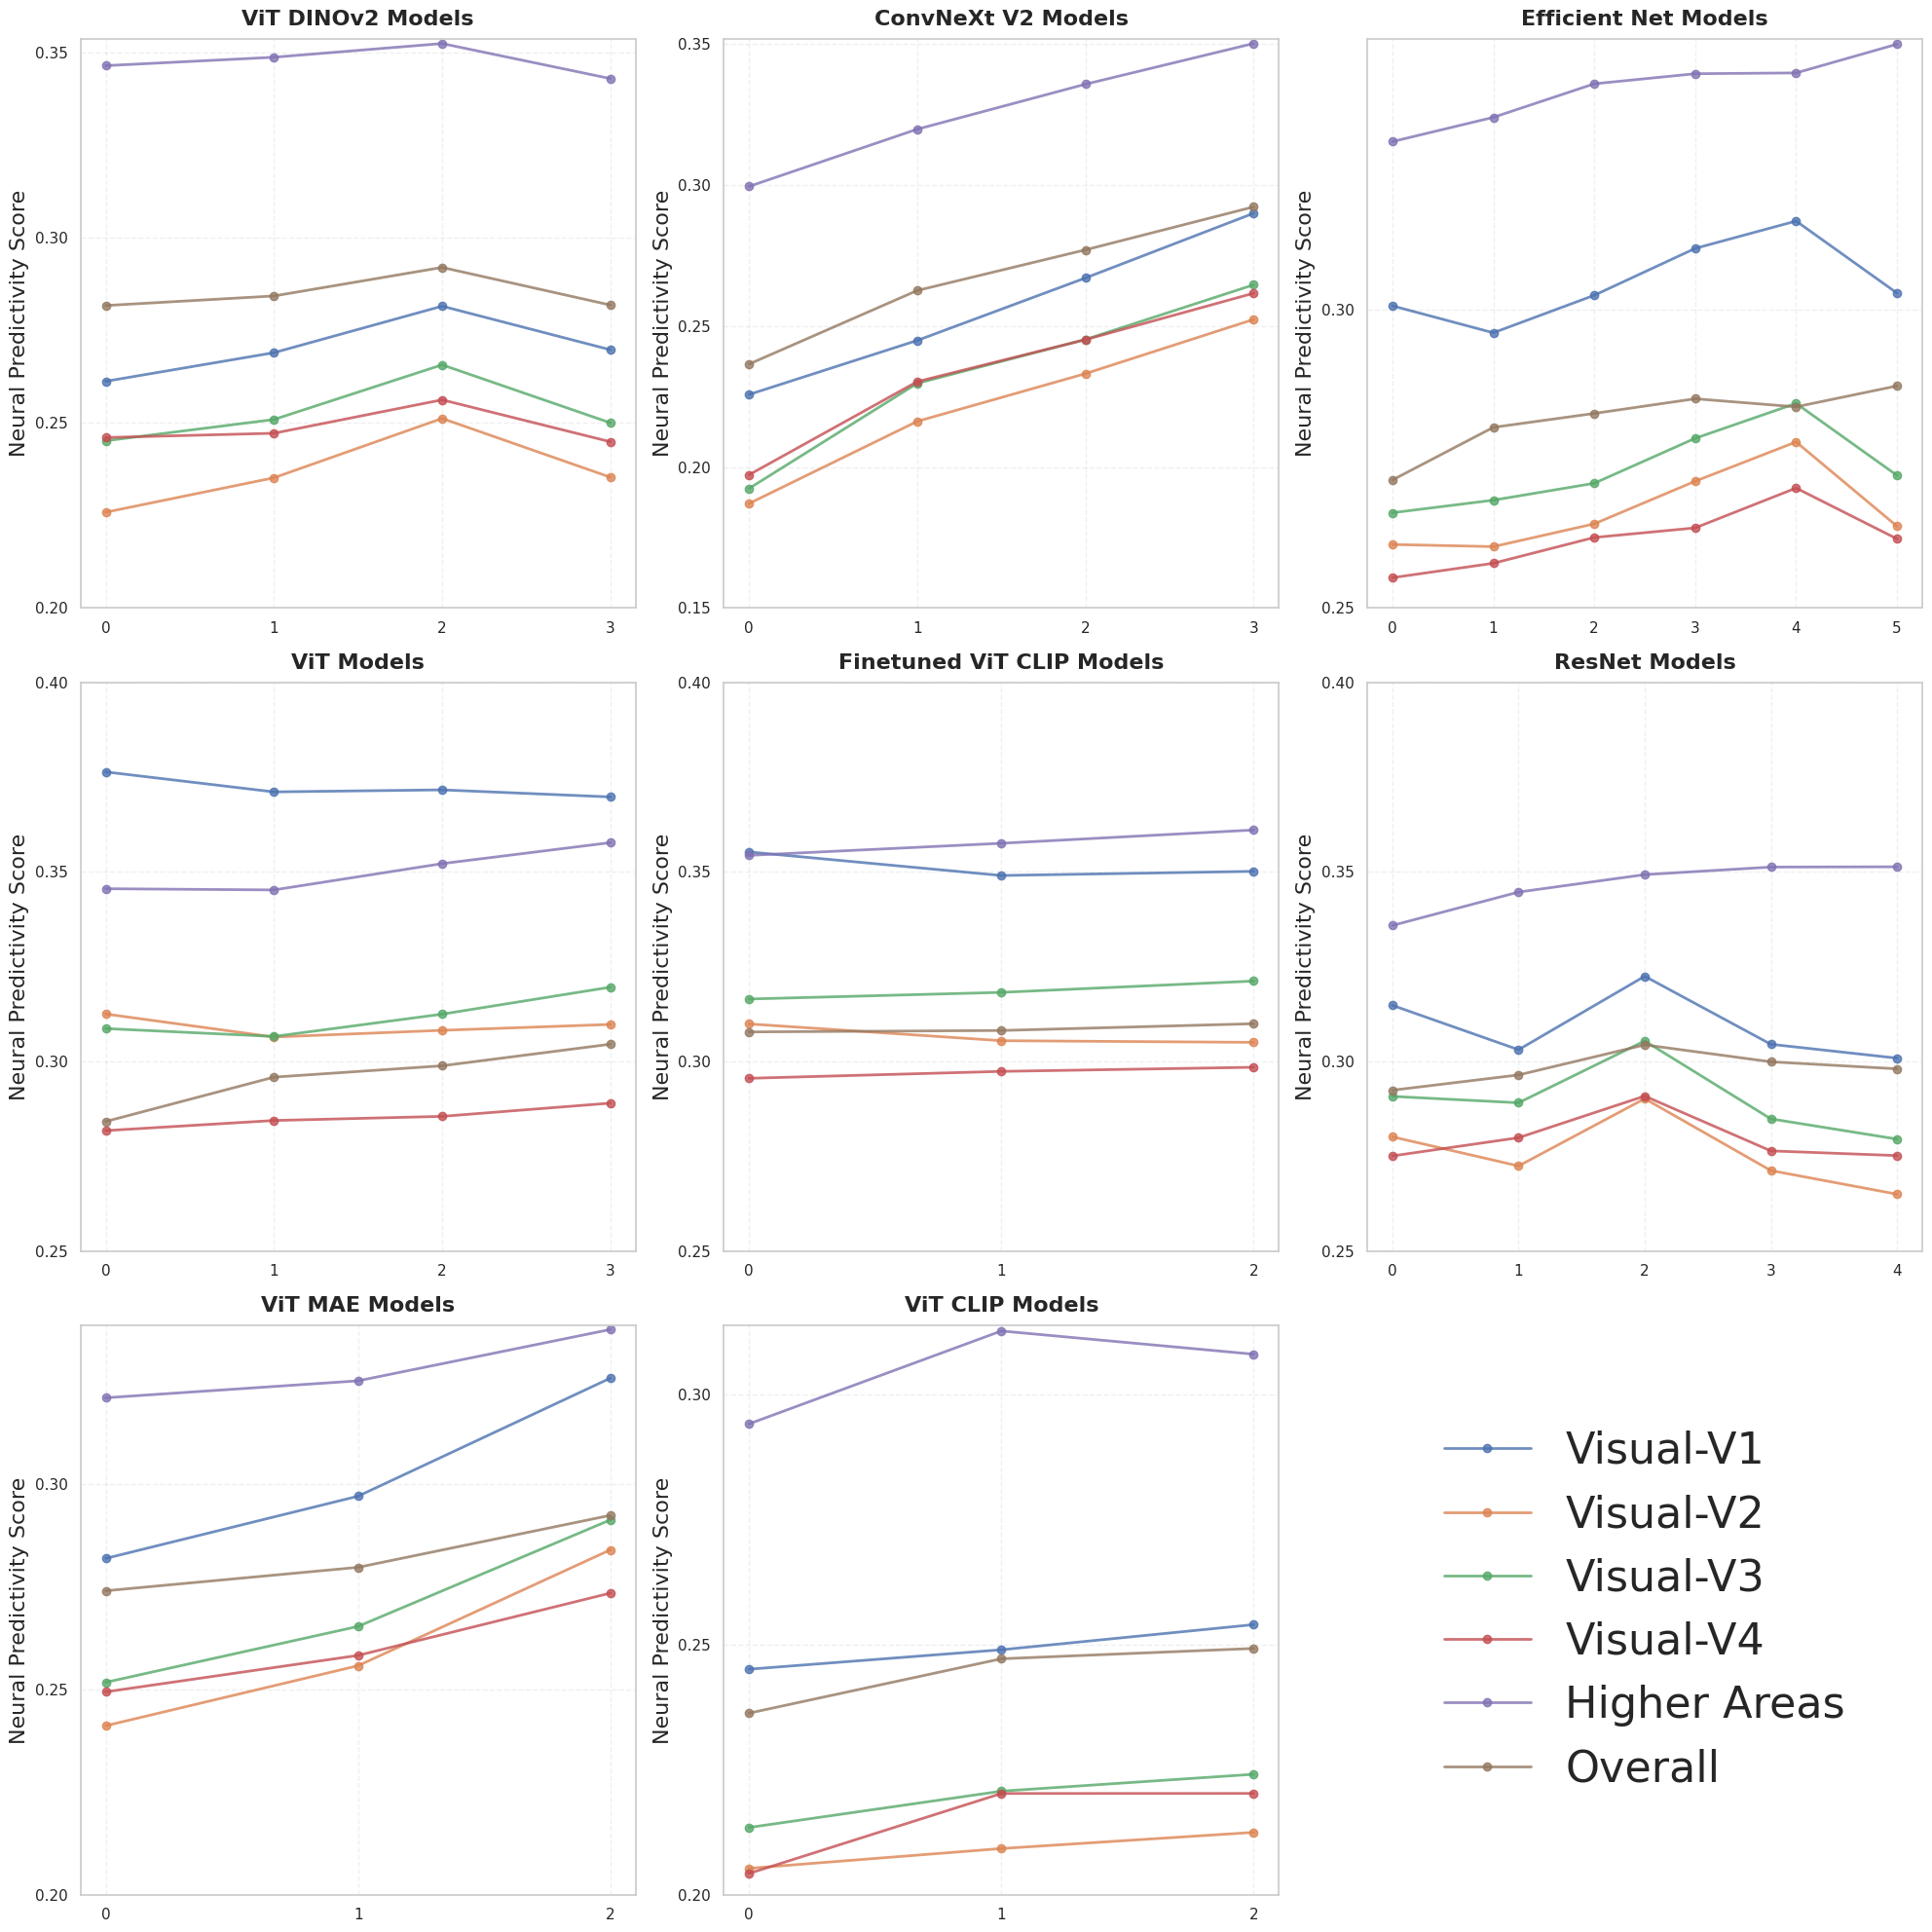

In [47]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Set seaborn style
sns.set_theme(style="whitegrid")
sns.set_palette("deep")

# Define regions of interest based on model family
default_regions = ['Visual-V1', 'Visual-V2', 'Visual-V3', 'Visual-V4', 'Higher Areas', 'Overall']
llm_regions = ['Visual-V1', 'Visual-V3', 'Visual-V4', 'Higher Areas']
llm_families = ['Bloomz', 'OpenLLaMA', 'LLaMA']

# Create figure and subplots with seaborn style
fig, axes = plt.subplots(3, 3, figsize=(20, 20))
axes = axes.ravel()

# Get unique families
families = results_db['family'].unique()
# Colors for different brain regions using seaborn color palette
colors = dict(zip(default_regions, sns.color_palette("deep", n_colors=len(default_regions))))
    
# Plot for each family
for idx, family in enumerate(families):
    # Select regions based on model family
    if family in llm_families:
        continue
        
            
    family_data = results_db[results_db['family'] == family]
    
    # Sort models by parameter size
    family_data = family_data.sort_values('num_params')
    
    # Get unique models for x-axis
    models = family_data['model'].unique()
    x = np.arange(len(models))
    
    min_score = float('inf')
    max_score = float('-inf')
    
    # Plot each brain region
    for region in default_regions:
        # Get mean scores for each model
        scores = [family_data[family_data['model'] == model][region].max() for model in models]
        axes[idx].plot(x, scores, 'o-', label=region, color=colors[region], 
                      linewidth=2, markersize=6, alpha=0.8)
        
        min_score = min(min_score, min(scores))
        max_score = max(max_score, max(scores))

    # Customize subplot
    axes[idx].set_title(f'{family} Models', fontsize=16, pad=10, fontweight='bold')
    axes[idx].set_xticks(x)
    axes[idx].set_ylabel('Neural Predictivity Score', fontsize=16)
    
    # Remove legend from all subplots
    if axes[idx].get_legend() is not None:
        axes[idx].get_legend().remove()
    
    # Add subtle background grid
    axes[idx].grid(True, linestyle='--', alpha=0.3)
    
    # Set y-axis limits individually for each subplot
    padding = (max_score - min_score) * 0.01 # 2% padding
    axes[idx].set_ylim(max(0, min_score - padding), max_score + padding)
    
    # Set y-ticks at 0.05 intervals
    y_min, y_max = axes[idx].get_ylim()
    axes[idx].set_yticks(np.arange(np.floor(y_min*20)/20, np.ceil(y_max*20)/20, 0.05))

# Use the last empty subplot for the legend if number of families is less than 12
if len(families) < 12:
    # Remove all empty subplots except the last one
    for i in range(len(families), 11):
        fig.delaxes(axes[i])
    
    # Clear the last subplot but keep it for legend
    axes[-1].clear()
    # Remove axes
    axes[-1].set_xticks([])
    axes[-1].set_yticks([])
    # Remove spines
    for spine in axes[-1].spines.values():
        spine.set_visible(False)
    
    # Create legend using the last subplot with seaborn styling
    # Use default_regions for legend as it contains all possible regions
    lines = [plt.Line2D([0], [0], color=dict(zip(default_regions, sns.color_palette("deep", n_colors=len(default_regions))))[region], 
                       linestyle='-', marker='o', linewidth=2, markersize=6, label=region, alpha=0.8) 
            for region in default_regions]
    axes[-1].legend(handles=lines, loc='center', fontsize=32, frameon=True, 
                   facecolor='white', edgecolor='none')

# Adjust layout
plt.tight_layout()

plt.savefig("figures/vision_encodings.pdf", bbox_inches='tight', dpi=300)

# Show plot
plt.show()

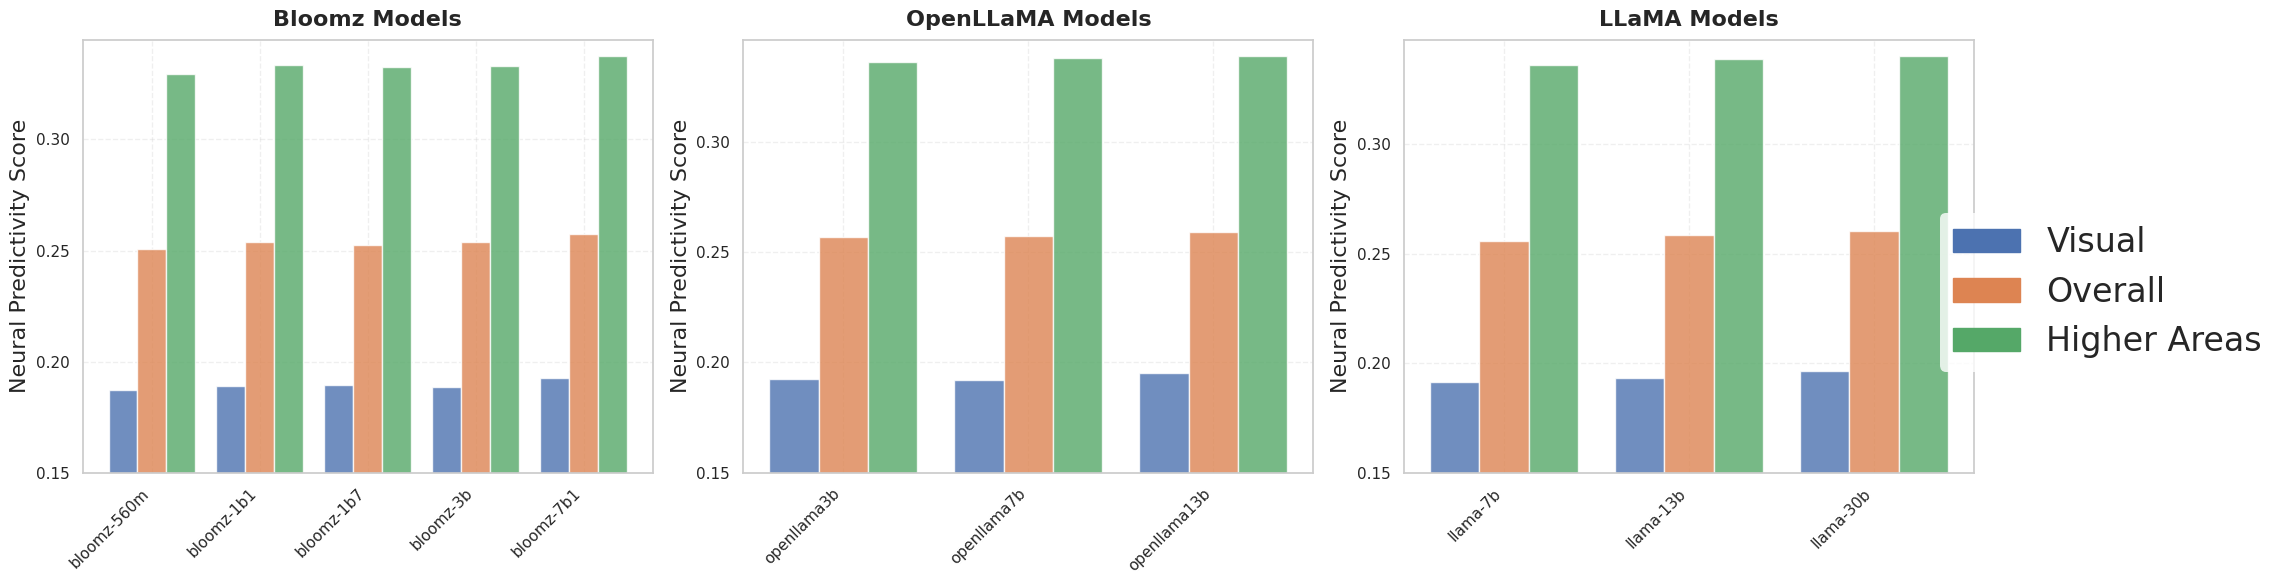

In [46]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Set seaborn style
sns.set_theme(style="whitegrid")
sns.set_palette("deep")

# Define regions for LLMs
llm_regions = ['Visual', 'Overall', 'Higher Areas']
llm_families = ['Bloomz', 'OpenLLaMA', 'LLaMA']


# Colors for different brain regions
colors = dict(zip(llm_regions, sns.color_palette("deep", n_colors=len(llm_regions))))

# Create figure
fig, axes = plt.subplots(1, len(llm_families), figsize=(20, 6))

# Plot for each LLM family
for idx, family in enumerate(llm_families):
    family_data = results_db[results_db['family'] == family]
    
    # Sort models by parameter size
    family_data = family_data.sort_values('num_params')
    models = family_data['model'].unique()
    
    # Calculate bar positions
    num_models = len(models)
    num_regions = len(llm_regions)
    bar_width = 0.8 / num_regions
    
    # Plot bars for each region
    for region_idx, region in enumerate(llm_regions):
        # Get scores for each model
        scores = [family_data[family_data['model'] == model][region].max() for model in models]
        
        # Calculate bar positions
        bar_positions = np.arange(num_models) + region_idx * bar_width - (num_regions-1) * bar_width/2
        
        # Plot bars
        axes[idx].bar(bar_positions, scores, bar_width, 
                     label=region, color=colors[region], alpha=0.8)
    
    # Customize subplot
    axes[idx].set_title(f'{family} Models', fontsize=16, pad=10, fontweight='bold')
    axes[idx].set_ylabel('Neural Predictivity Score', fontsize=16)
    axes[idx].set_xticks(np.arange(num_models))
    axes[idx].set_xticklabels([m.split('/')[-1] for m in models], rotation=45, ha='right')
    
    # Add subtle background grid
    axes[idx].grid(True, linestyle='--', alpha=0.3)
    
    # Set y-axis limits
    max_score = max(family_data[region].max() for region in llm_regions)
    min_score = min(family_data[region].max() for region in llm_regions)
    padding = (max_score - min_score) * 0.05
    axes[idx].set_ylim(max(0, min_score - padding), max_score + padding)
    
    # Set y-ticks at 0.05 intervals
    y_min, y_max = axes[idx].get_ylim()
    axes[idx].set_yticks(np.arange(np.floor(y_min*20)/20, np.ceil(y_max*20)/20, 0.05))

# Add legend to the right of the last subplot
lines = [plt.Rectangle((0,0),1,1, color=colors[region]) for region in llm_regions]

fig.legend(lines, llm_regions, 
          loc='center right', 
          bbox_to_anchor=(1.15, 0.5),
          fontsize=24,
          frameon=True,
          facecolor='white',
          edgecolor='none')

# Adjust layout
plt.tight_layout()

plt.savefig("figures/llm_encodings.pdf", bbox_inches='tight', dpi=300)

# Show plot
plt.show()

In [11]:
results_db[(results_db['family'] == 'Bloomz')]['model'].unique()

array(['bigscience/bloomz-560m', 'bigscience/bloomz-1b1',
       'bigscience/bloomz-1b7', 'bigscience/bloomz-3b',
       'bigscience/bloomz-7b1'], dtype=object)

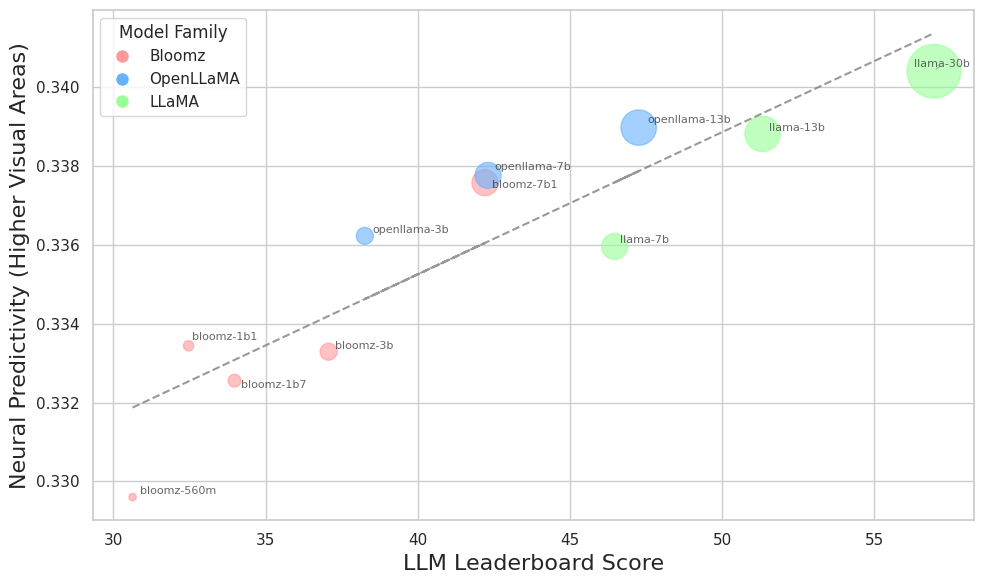

In [48]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from adjustText import adjust_text  # You might need to pip install adjustText

# Set seaborn style
sns.set_theme(style="whitegrid")

# Create figure
plt.figure(figsize=(10, 6))

# Your existing dictionaries (llm_leaderboard, model_size_dict, family_colors)...
# Huggingface LLM Learderboard Score
llm_leaderboard = {
    "bigscience/bloomz-560m": 30.63,
    "bigscience/bloomz-1b1": 32.47,
    "bigscience/bloomz-1b7": 33.98,
    "bigscience/bloomz-3b": 37.07,
    "bigscience/bloomz-7b1": 42.21,
    "openlm-research/openllama3b": 38.26,
    "openlm-research/openllama7b": 42.31,
    "openlm-research/openllama13b": 47.26,
    "huggyllama/llama-7b": 46.47,
    "huggyllama/llama-13b": 51.33,
    "huggyllama/llama-30b": 56.96

}

model_size_dict = {
    "560m": 0.56,
    "1b1": 1.1,
    "1b7": 1.7,
    "3b": 3,
    "7b": 7,
    "7b1": 7.1,
    "13b": 13,
    "30b": 30
}

# Process data
x_scores = []
y_scores = []
sizes = []
colors = []
texts = []  # Will store annotation objects

for model in llm_leaderboard.keys():
    model_name = model
    
    if 'bigscience' in model:
        family = 'Bloomz'
        model_data = results_db[(results_db['family'] == 'Bloomz') & 
                              (results_db['model'] == model_name)]
    elif 'openlm' in model:
        family = 'OpenLLaMA'
        model_data = results_db[(results_db['family'] == 'OpenLLaMA') & 
                              (results_db['model'] == model_name)]
    else:
        family = 'LLaMA'
        model_data = results_db[(results_db['family'] == 'LLaMA') & 
                              (results_db['model'] == model_name)]
    
    if not model_data.empty:
        x_scores.append(llm_leaderboard[model])
        y_scores.append(model_data['Higher Areas'].max())
        
        if not 'openlm' in model:
            size = model_size_dict[model_name.split('-')[-1]]
        else:
            size = model_size_dict[model_name.split('llama')[-1]]
        sizes.append(size * 50)
        
        colors.append(family_colors[family])
        # Store shortened model names for cleaner annotations
        if 'bigscience' in model:
            label = f"bloomz-{model.split('-')[-1]}"
        elif 'openlm' in model:
            label = f"openllama-{model.split('llama')[-1]}"
        else:
            label = f"llama-{model.split('-')[-1]}"
        texts.append(label)

# Create scatter plot
scatter = plt.scatter(x_scores, y_scores, s=sizes, c=colors, alpha=0.6)

# Add trend line
z = np.polyfit(x_scores, y_scores, 1)
p = np.poly1d(z)
plt.plot(x_scores, p(x_scores), "--", color="gray", alpha=0.8)

# Customize plot
plt.xlabel('LLM Leaderboard Score', fontsize=16)
plt.ylabel('Neural Predictivity (Higher Visual Areas)', fontsize=16)
# plt.title('LLM Performance vs Neural Predictivity', fontsize=14)

# Add legend for model families
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                            markerfacecolor=color, label=family, markersize=10)
                  for family, color in family_colors.items()]
plt.legend(handles=legend_elements, title='Model Family', 
          loc='upper left', frameon=True)

# Add annotations with adjustText
annotations = []
for i, (x, y, text) in enumerate(zip(x_scores, y_scores, texts)):
    annotations.append(plt.annotate(text, (x, y), fontsize=8, alpha=0.7))

# Use adjustText to prevent overlap
adjust_text(annotations, 
           arrowprops=dict(arrowstyle='-', color='gray', alpha=0.5),
           expand_points=(1.5, 1.5))

# Adjust layout
plt.tight_layout()
plt.savefig("figures/llm_trend.pdf", bbox_inches='tight', dpi=300)
# Show plot
plt.show()

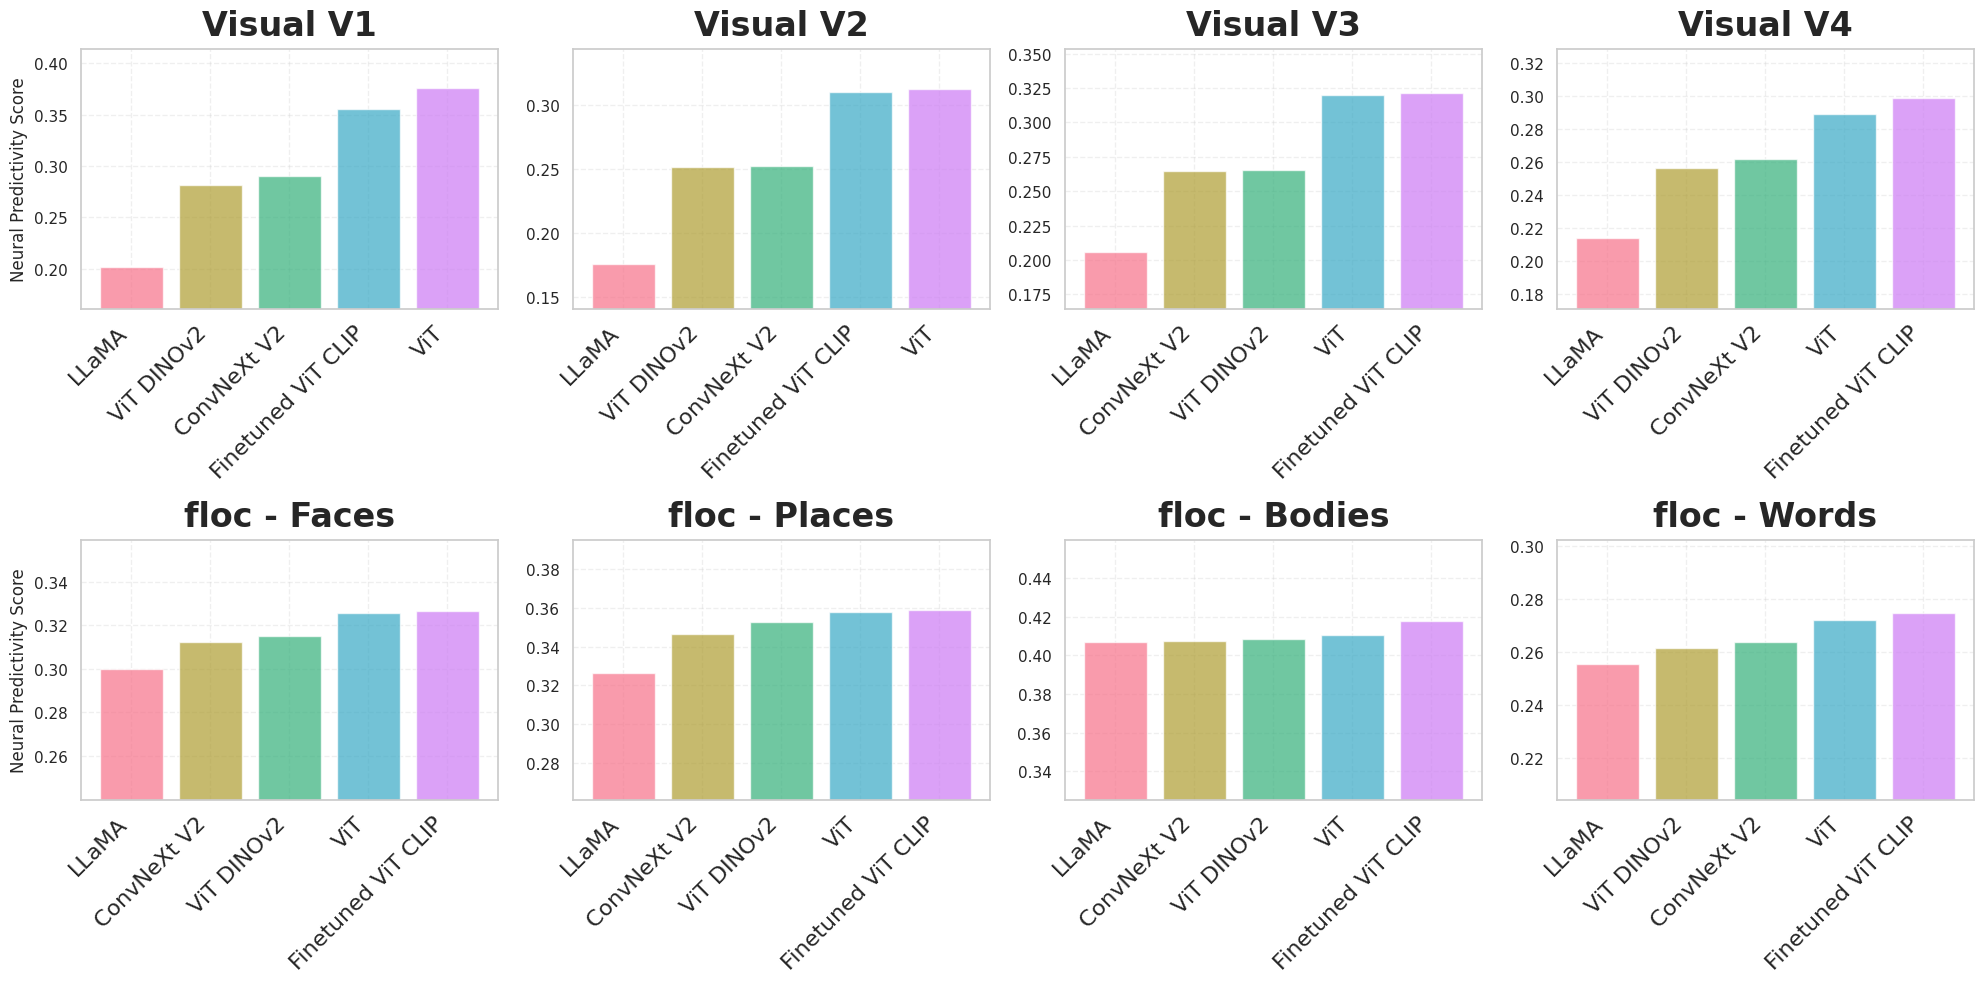

In [49]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Set seaborn style
sns.set_theme(style="whitegrid")

# Define regions
visual_regions = ['Visual-V1', 'Visual-V2', 'Visual-V3', 'Visual-V4']
floc_regions = ['floc-faces', 'floc-places', 'floc-bodies', 'floc-words']
all_regions = visual_regions + floc_regions

# Create figure
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

# Get unique families excluding specified ones
families = [f for f in results_db['family'].unique() 
           if f not in ['ResNet', 'Efficient Net', 'Bloomz', 'OpenLLaMA',
                       'ViT MAE', 'ViT CLIP']]

# Plot for each region
for row in range(2):
    for col in range(4):
        ax = axes[row, col]
        
        if row == 0:
            region = visual_regions[col]
            title = f"Visual {region.split('-')[-1]}"
        else:
            region = floc_regions[col]
            title = f"floc - {region.split('-')[-1].capitalize()}"
        
        # Calculate scores and create dictionary for sorting
        scores_dict = {}
        for family in families:
            family_data = results_db[results_db['family'] == family][region]
            scores_dict[family] = family_data.max()
        
        # Sort families based on scores
        sorted_families = sorted(scores_dict.keys(), key=lambda x: scores_dict[x])
        sorted_scores = [scores_dict[f] for f in sorted_families]
        
        # Create color palette for sorted families
        colors = sns.color_palette("husl", n_colors=len(sorted_families))
        
        # Create bar plot
        x = np.arange(len(sorted_families))
        bars = ax.bar(x, sorted_scores, 
                     color=colors,
                     alpha=0.7)
        
        # Customize subplot
        ax.set_title(title, fontsize=24, pad=10, fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels(sorted_families, rotation=45, ha='right', fontsize=16)
        
        if col == 0:
            ax.set_ylabel('Neural Predictivity Score')
        
        # Set y-axis limits
        ax.set_ylim(min(sorted_scores)*0.8, max(sorted_scores) * 1.1)
        
        # Add grid
        ax.grid(True, linestyle='--', alpha=0.3)

# Adjust layout
plt.tight_layout()
plt.savefig("figures/model_families.pdf", bbox_inches='tight', dpi=300)
# Show plot
plt.show()

In [38]:
# Define vision and language model families
vision_families = ['ViT DINOv2', 'ConvNeXt V2', 'ViT', 'Finetuned ViT CLIP', 
                  'ResNet', 'Efficient Net', 'ViT MAE', 'ViT CLIP']
language_families = ['Bloomz', 'OpenLLaMA', 'LLaMA']

# First, find the best vision model
vision_models = results_db[results_db['family'].isin(vision_families)]
# We can average across all regions for overall performance
regions = ['Overall']
vision_models['mean_performance'] = vision_models[regions].mean(axis=1)
best_vision = vision_models.loc[vision_models['mean_performance'].idxmax()]

# Similarly for language models
language_models = results_db[results_db['family'].isin(language_families)]
language_models['mean_performance'] = language_models[regions].mean(axis=1)
best_language = language_models.loc[language_models['mean_performance'].idxmax()]

print(best_vision.model, best_vision.layer, best_vision.pooling)
print(best_language.model, best_language.layer, best_language.pooling)

vithugepatch14clip224.laion2bftin12k blocks.11 mean
huggyllama/llama-30b layer_34 mean


In [39]:
best_vision = read_pickle('alignment_scores/subj01/general/vision/vit_neural_predictivity_top10.pkl')[
    'vit_huge_patch14_clip_224.laion2b_ft_in12k_blocks.11_mean'
]['score'][(0, 0)]

best_language = read_pickle('alignment_scores/subj01/general/language/huggyllama_neural_predictivity_top10.pkl')[
    'huggyllama/llama-30b_all_mean'
]['score'][(0, 34)]

In [20]:
# np.save( "best_vision.npy", best_vision)
# np.save("best_language.npy", best_language)

# best_vision = np.load('best_vision.npy')
# best_language = np.load('best_language.npy')

# # nsd_general_roi = np.expand_dims(nsd_general_roi, -1)
# # nsd_general_roi = np.repeat(nsd_general_roi, 3, axis=-1)
# # nsd_general_roi.shape

In [40]:
from nsdcode.nsd_mapdata import NSDmapdata

def to_fsaverage(array):
    nsd = NSDmapdata('/SSD/slava/brain_decoding/nsd/data/')
    lh_data = []
    for p in range(3):
        lh_data.append(
            nsd.fit(
                1,
                'func1pt8',
                f'lh.layerB{p+1}',
                nsd_general_roi,
                'cubic',
                badval=0
             )

        )
    
    rh_data = []
    for p in range(3):
        rh_data.append(
            nsd.fit(
                1,
                'func1pt8',
                f'rh.layerB{p+1}',
                nsd_general_roi,
                'cubic',
                badval=0
             )

        )
    
    lh_data = np.vstack(np.asarray(lh_data))
    lh_output = nsd.fit(1,
           'lh.white',
           'fsaverage',
           np.mean(lh_data, axis=0),
           interptype=None,
           badval=0)
    
    rh_data = np.vstack(np.asarray(rh_data))
    rh_output = nsd.fit(1,
           'rh.white',
           'fsaverage',
           np.mean(rh_data, axis=0),
           interptype=None,
           badval=0)
    
    
    return lh_output, rh_output
    



In [41]:
nsd_general_roi = nib.load('/SSD/slava/THESIS/NSD_processed/subj01/roi/nsdgeneral.nii.gz').get_fdata()
nsd_general_roi[nsd_general_roi>0] = best_vision
nsd_general_roi[nsd_general_roi<0] = 0

lh_vision, rh_vision = to_fsaverage(nsd_general_roi)

nsd_general_roi = nib.load('/SSD/slava/THESIS/NSD_processed/subj01/roi/nsdgeneral.nii.gz').get_fdata()
nsd_general_roi[nsd_general_roi>0] = best_language
nsd_general_roi[nsd_general_roi<0] = 0

lh_language, rh_language = to_fsaverage(nsd_general_roi)

data array passed
data array passed
data array passed
data array passed
data array passed
data array passed
data array passed
data array passed
data array passed
data array passed
data array passed
data array passed
data array passed
data array passed
data array passed
data array passed


In [23]:
subject = 'fsaverage'
# data = np.append(lh_vision, rh_vision) * 100
# data[data<0] = 0
# vertex_data = cortex.Vertex(data, subject, cmap='hot', vmin=0, vmax=100)
# cortex.quickshow(vertex_data)
# plt.show()
# manager = plt.get_current_fig_manager()
# # manager.window.showMaximized()



(327684,)
Unable to init server: Could not connect: Connection refused
** (inkscape:42234): WARNING **: 19:03:56.074: Fonts dir '/home/slava/.config/inkscape/fonts' does not exist and will be ignored.
Background RRGGBBAA: ffffff00
Area 0:0:2274.66:1024 exported to 2275 x 1024 pixels (96 dpi)


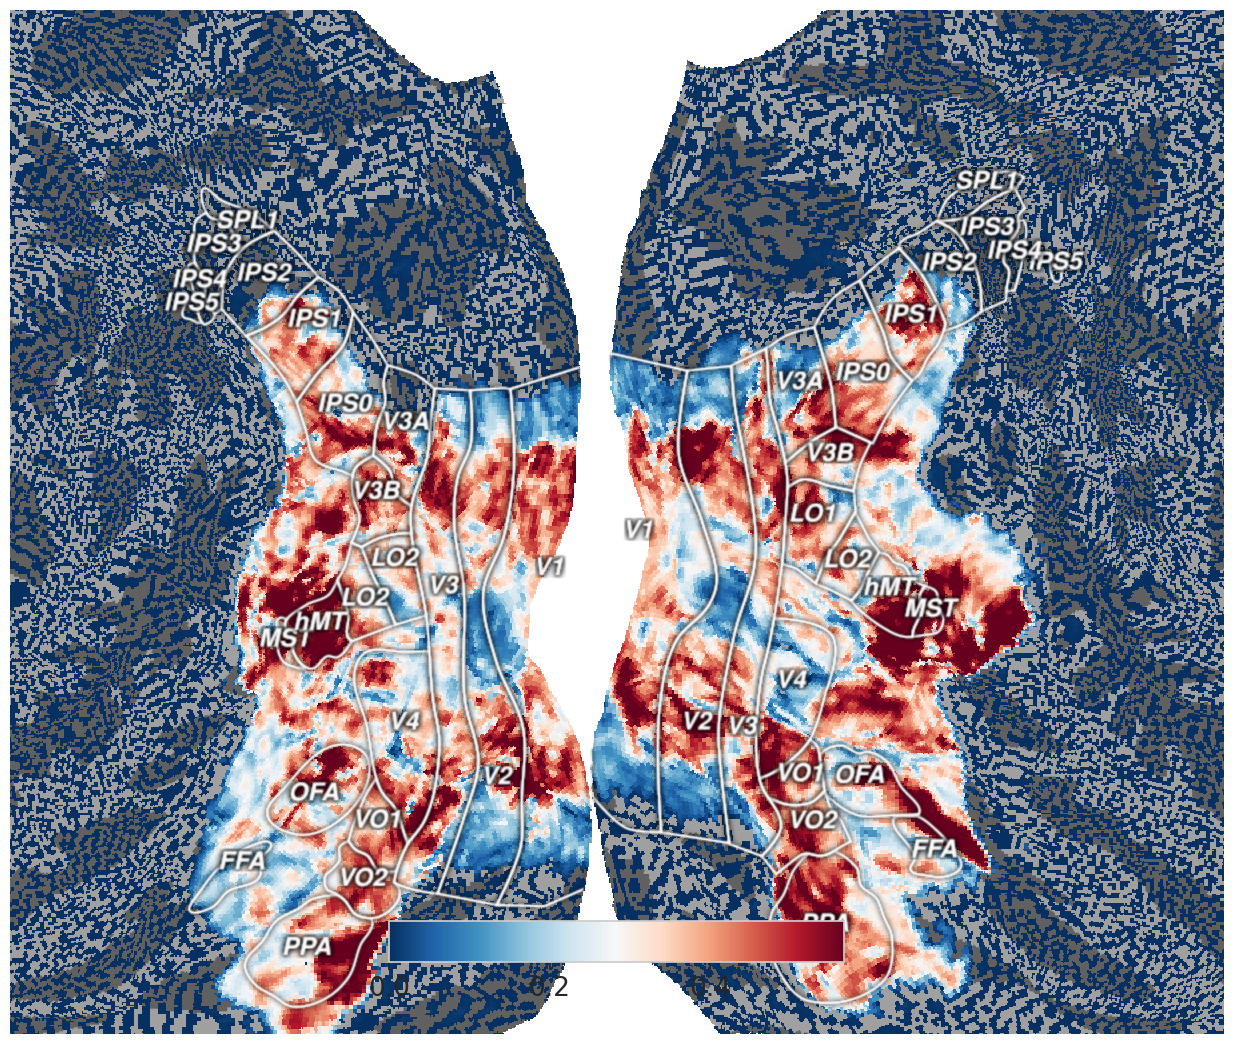

In [65]:
from matplotlib.transforms import Bbox

# =============================================================================
# Plot parameters for colorbar
# =============================================================================
plt.rc('xtick', labelsize=19)
plt.rc('ytick', labelsize=19)

# Plot the full surface
data = np.append(lh_vision, rh_vision)
print(data.shape)
data[data<=0] = np.nan # 40
vertex_data = cortex.Vertex(data, subject, cmap='RdBu_r', with_colorbar=False)
fig = cortex.quickshow(vertex_data, with_curvature=True, with_colorbar=True)

# plt.savefig("figures/best_vision_encoding.pdf")
# plt.show()


# Get current axis
ax = plt.gca()

# Set the view limits to focus on the center
x_center = (ax.get_xlim()[1] + ax.get_xlim()[0]) / 2
y_center = (ax.get_ylim()[1] + ax.get_ylim()[0]) / 2
width = ax.get_xlim()[1] - ax.get_xlim()[0]
height = ax.get_ylim()[1] - ax.get_ylim()[0]

# Adjust these factors to control how much to crop
crop_factor_x = 0.4  # Smaller value = more crop
crop_factor_y = 0.75  # Smaller value = more crop

ax.set_xlim(x_center - width*crop_factor_x/2, x_center + width*crop_factor_x/2)
ax.set_ylim(y_center - height*crop_factor_y/2, y_center + height*crop_factor_y/2)

plt.savefig("figures/best_vision_encoding.pdf", dpi=300, bbox_inches='tight')
plt.show()


#plt.savefig('algonauts_2023_full_surface_template.png', transparent=True, dpi=100)

# Plot the challenge vertices surface --> ['PiYG', 'RdPu_r']
# data = np.append(lh_vision, rh_vision)
# idx = np.isnan(data)
# data[idx] = 0.05
# vertex_data = cortex.Vertex(data, subject, cmap='PiYG', vmin=0, vmax=1.0)
# cortex.quickshow(vertex_data, with_colorbar=True)
# plt.show()

Unable to init server: Could not connect: Connection refused
** (inkscape:23920): WARNING **: 19:17:55.995: Fonts dir '/home/slava/.config/inkscape/fonts' does not exist and will be ignored.
Background RRGGBBAA: ffffff00
Area 0:0:2274.66:1024 exported to 2275 x 1024 pixels (96 dpi)


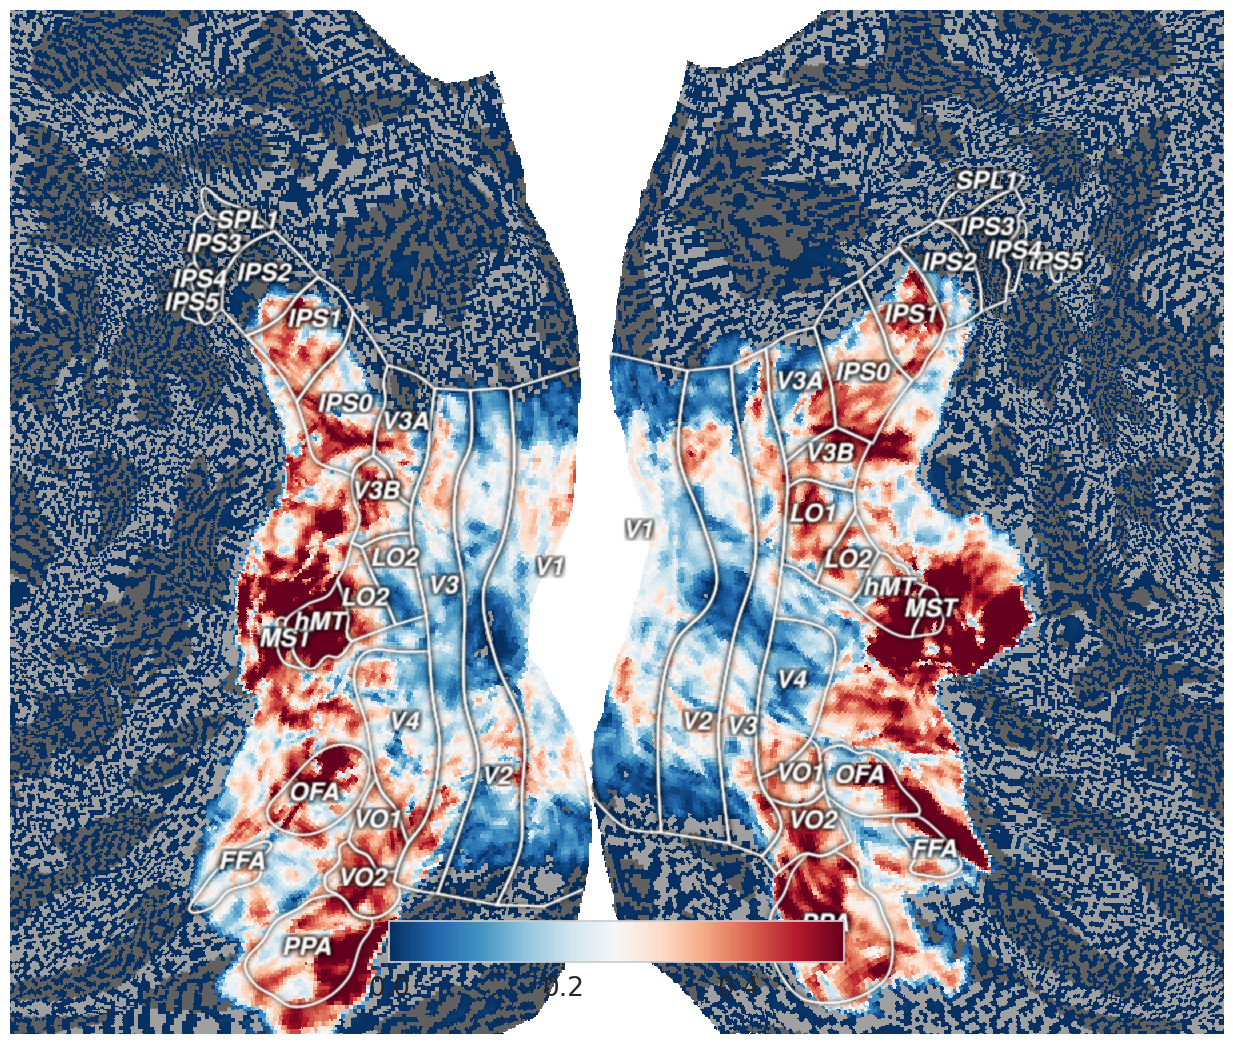

In [67]:

# =============================================================================
# Plot parameters for colorbar
# =============================================================================
plt.rc('xtick', labelsize=19)
plt.rc('ytick', labelsize=19)

# Plot the full surface
data = np.append(lh_language, rh_language)
data[data<=0] = np.nan # 40
vertex_data = cortex.Vertex(data, subject, cmap='RdBu_r', with_colorbar=False)
fig = cortex.quickshow(vertex_data, with_curvature=True, with_colorbar=True)

# plt.savefig("figures/best_language_encoding.pdf")
# plt.show()
#plt.savefig('algonauts_2023_full_surface_template.png', transparent=True, dpi=100)

# Get current axis
ax = plt.gca()

# Set the view limits to focus on the center
x_center = (ax.get_xlim()[1] + ax.get_xlim()[0]) / 2
y_center = (ax.get_ylim()[1] + ax.get_ylim()[0]) / 2
width = ax.get_xlim()[1] - ax.get_xlim()[0]
height = ax.get_ylim()[1] - ax.get_ylim()[0]

# Adjust these factors to control how much to crop
crop_factor_x = 0.4  # Smaller value = more crop
crop_factor_y = 0.75  # Smaller value = more crop

ax.set_xlim(x_center - width*crop_factor_x/2, x_center + width*crop_factor_x/2)
ax.set_ylim(y_center - height*crop_factor_y/2, y_center + height*crop_factor_y/2)

plt.savefig("figures/best_language_encoding.pdf", dpi=300, bbox_inches='tight')
plt.show()


# Plot the challenge vertices surface --> ['PiYG', 'RdPu_r']
# data = np.append(lh_fsaverage, rh_fsaverage)
# idx = ~np.isnan(data)
# data[idx] = 5
# vertex_data = cortex.Vertex(data, subject, cmap='PiYG')
# cortex.quickshow(vertex_data, with_colorbar=True)
# plt.show()